# Experiment notebook

In [4]:
# Load the image and label map
import nibabel as nib
import numpy as np
image = nib.load('brainmaskconverted_synthseg.nii.gz')
image_data = image.get_fdata()
image_data.shape
print(len(np.unique(image_data)))

33


In [5]:
from sklearn.cluster import KMeans

def kmeans_nifti(image_path, output_path, n_clusters):
    image = nib.load(image_path)
    data = image.get_fdata()

    # Flatten the data and remove background (optional: assuming background is zero)
    flat_data = data.reshape(-1)
    nonzero_mask = flat_data != 0
    nonzero_data = flat_data[nonzero_mask].reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(nonzero_data)

    # Create the clusters array with the same shape as the original data
    clusters = np.zeros(flat_data.shape, dtype=np.int32)
    clusters[nonzero_mask] = kmeans.labels_ + 1  # +1 to label clusters starting from 1

    # Reshape clusters back to the original image shape
    clusters = clusters.reshape(data.shape)

    # Create a new NIfTI image for the clusters
    cluster_img = nib.Nifti1Image(clusters, affine=image.affine, header=image.header)

    # Save the clusters image to a file
    nib.save(cluster_img, output_path)

In [29]:
kmeans_nifti('brainmaskconverted.nii.gz', 'test.nii.gz', 38)
clustered = nib.load('test.nii.gz')
clustered_data = clustered.get_fdata()
np.unique(clustered_data)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.])

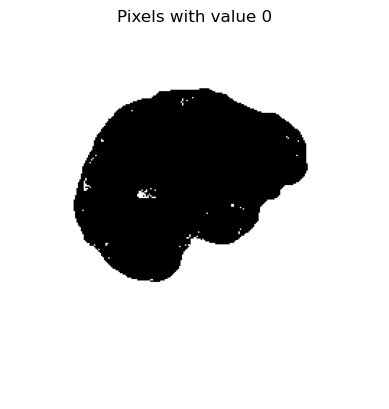

0


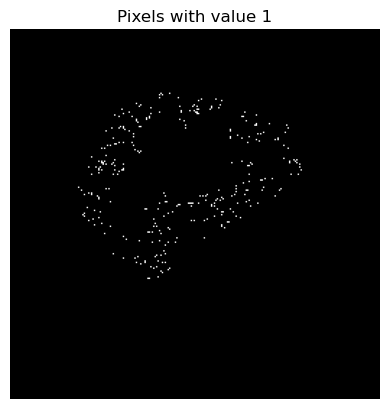

1


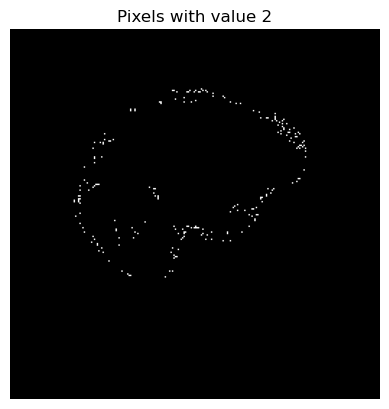

2


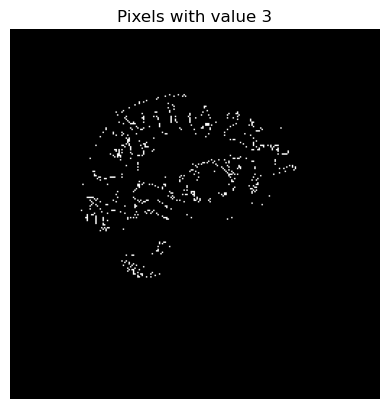

3


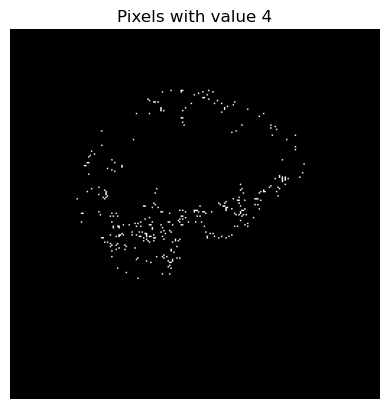

4


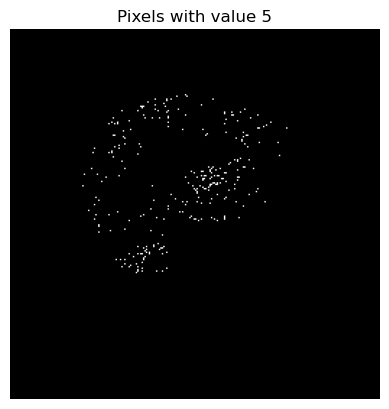

5


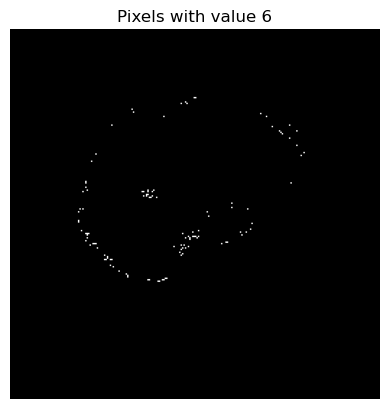

6


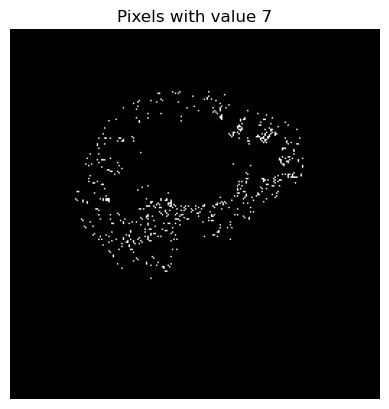

7


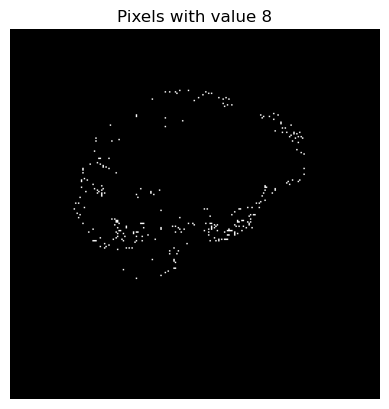

8


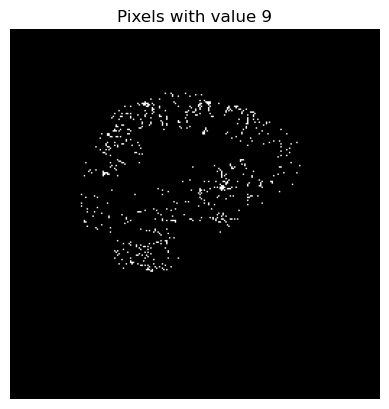

9


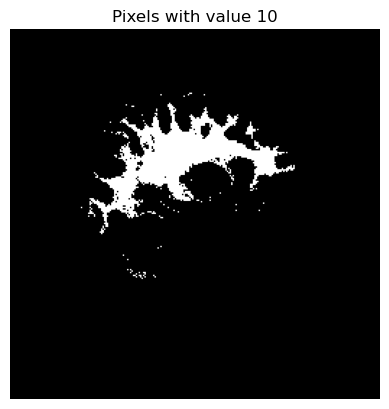

10


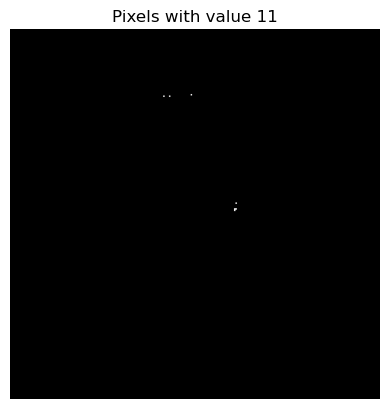

11


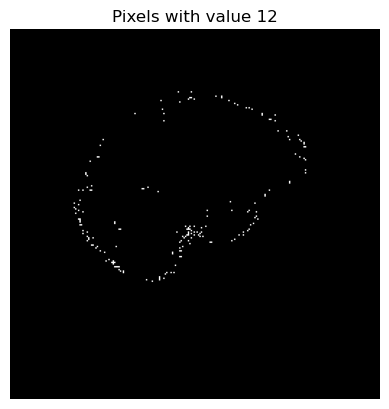

12


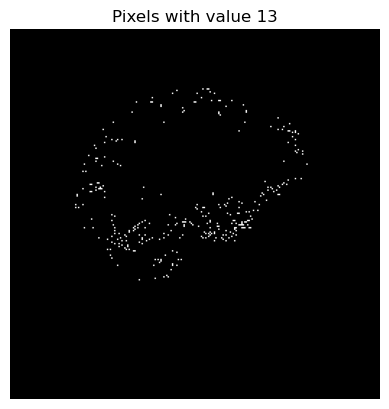

13


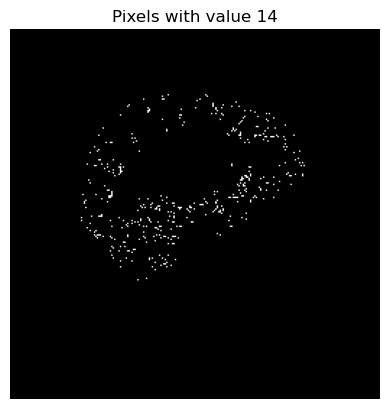

14


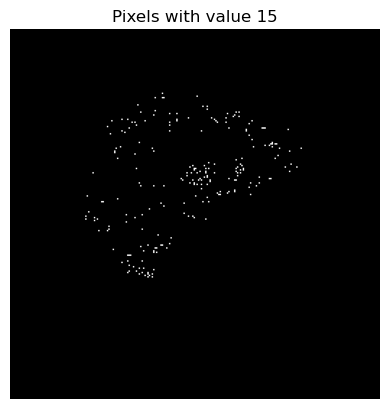

15


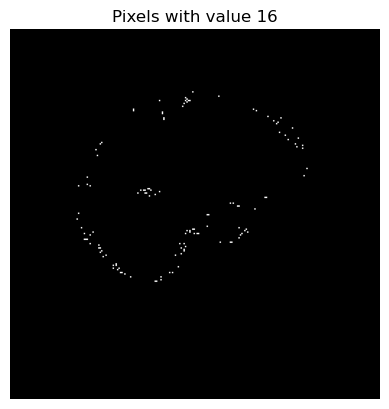

16


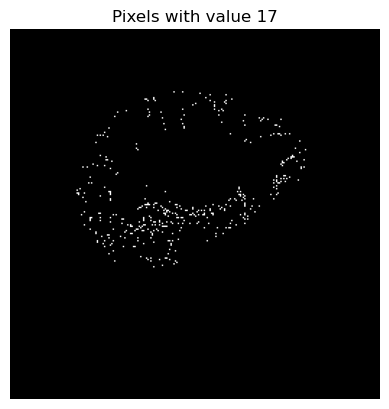

17


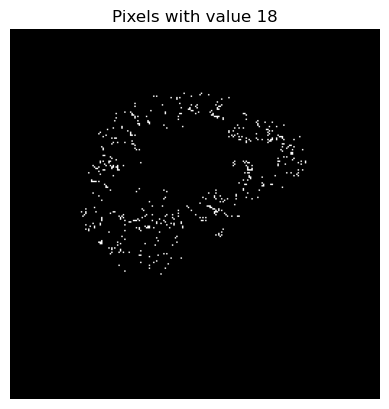

18


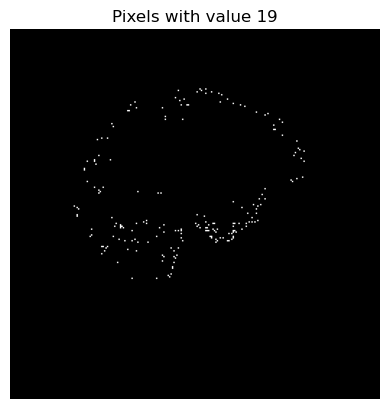

19


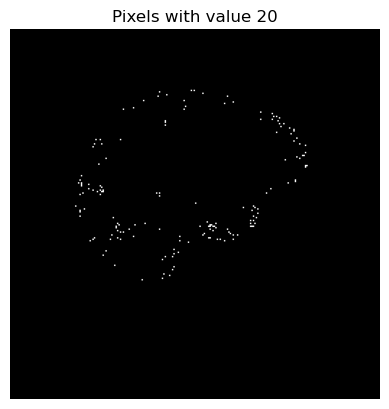

20


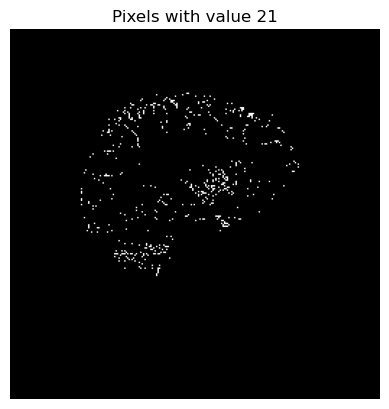

21


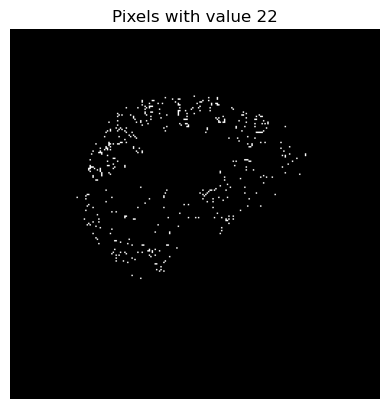

22


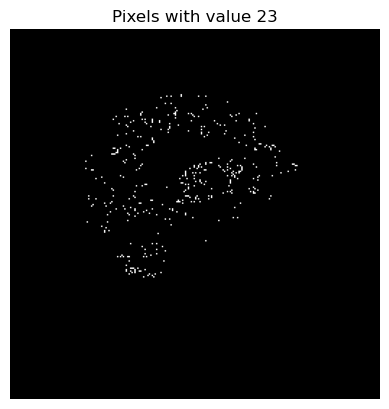

23


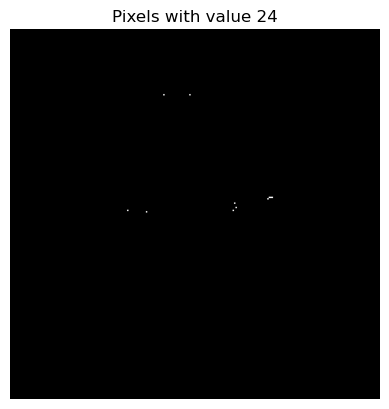

24


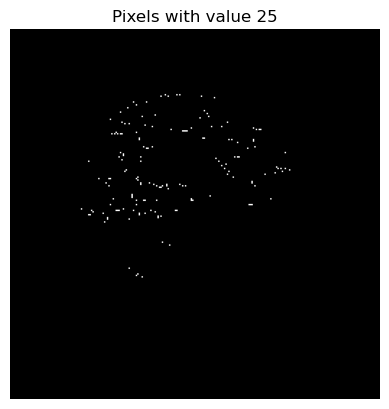

25


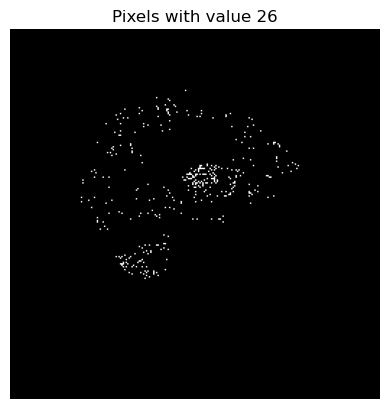

26


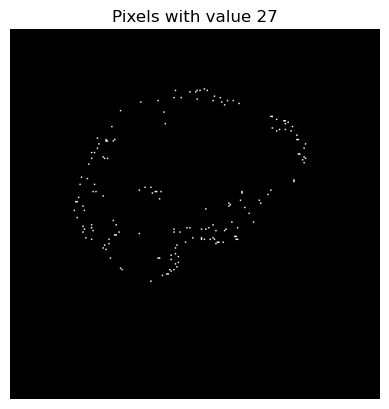

27


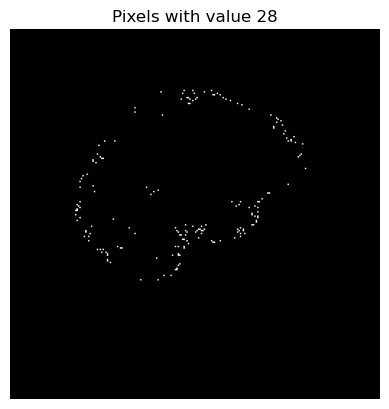

28


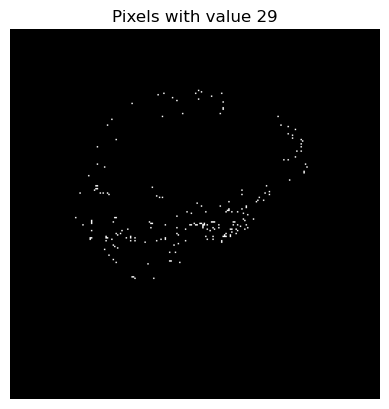

29


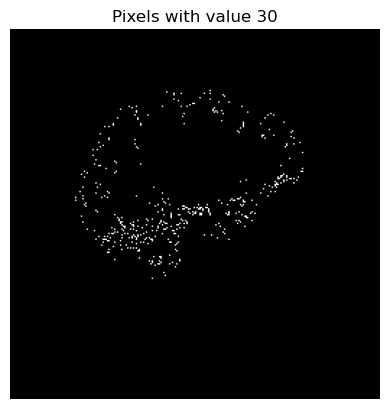

30


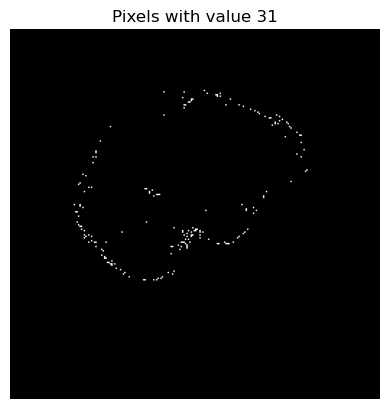

31


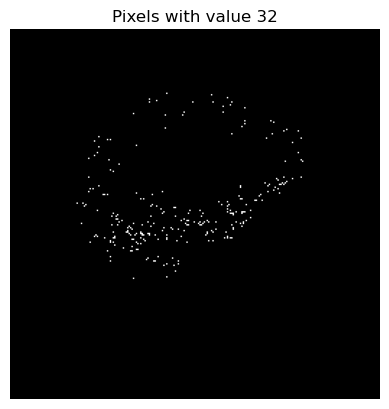

32


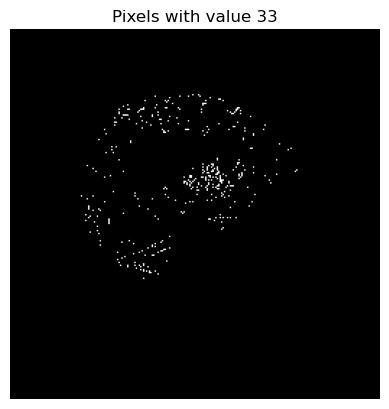

33


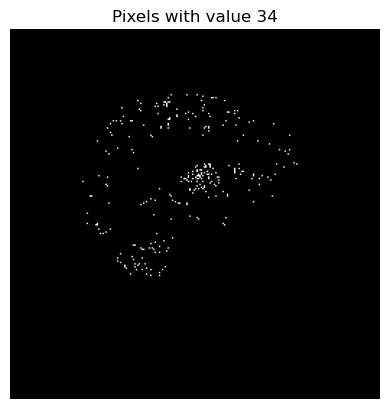

34


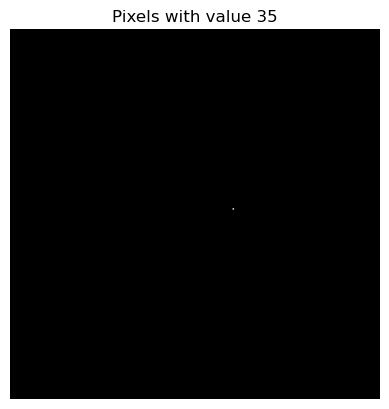

35


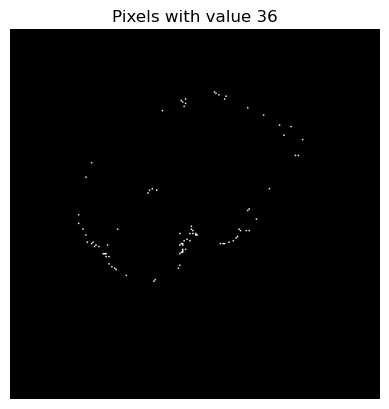

36


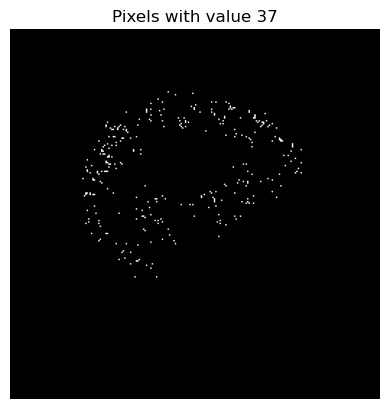

37


In [30]:
import matplotlib.pyplot as plt
for i in range(38):
    # Create a binary image where pixels with value i are set to 1, others set to 0
    binary_image = (clustered_data == i).astype(int)
    
    # Plot the binary image
    plt.imshow(binary_image[100], cmap='gray')
    plt.title(f'Pixels with value {i}')
    plt.axis('off')  # Hide axis for better visualization
    plt.show()
    print(i)

In [ ]:
clustered_real = nib.load('brainmaskconverted_synthseg.nii.gz')
clustered_real_data = clustered_real.get_fdata()
unique_vals = np.unique(clustered_real_data)
import matplotlib.pyplot as plt
for i in unique_vals:
    # Create a binary image where pixels with value i are set to 1, others set to 0
    binary_image = (clustered_real_data == i).astype(int)
    # Plot the binary image
    plt.imshow(binary_image[100], cmap='gray')
    plt.title(f'Pixels with value {i}')
    plt.axis('off')  # Hide axis for better visualization
    plt.show()
    print(i)

In [25]:
import nibabel as nib
import numpy as np
from collections import Counter

# Load the NIfTI images
reference_img = nib.load('brainmaskconverted_synthseg.nii.gz')
target_img = nib.load('test.nii.gz')

# Get the data arrays
reference_data = reference_img.get_fdata().astype(int)
target_data = target_img.get_fdata().astype(int)

# Create an empty array for the new corrected labels
corrected_labels = np.zeros_like(target_data)

# Iterate through each label in the reference image
unique_labels = np.unique(reference_data)
for label in unique_labels:
    if label == 0:  # Assuming 0 is the background and should be ignored
        continue
    
    # Find the region in the target image corresponding to the current label in the reference image
    region_mask = (reference_data == label)
    
    # Find the most common label in this region of the target image
    region_labels = target_data[region_mask]
    most_common_label = Counter(region_labels).most_common(1)[0][0]
    
    # Update the corrected labels image
    corrected_labels[target_data == most_common_label] = label

# Save the corrected labels as a new NIfTI image
corrected_img = nib.Nifti1Image(corrected_labels, reference_img.affine, reference_img.header)
nib.save(corrected_img, 'corrected_segmentation.nii')

print("Corrected segmentation map saved as 'corrected_segmentation.nii'")

Corrected segmentation map saved as 'corrected_segmentation.nii'


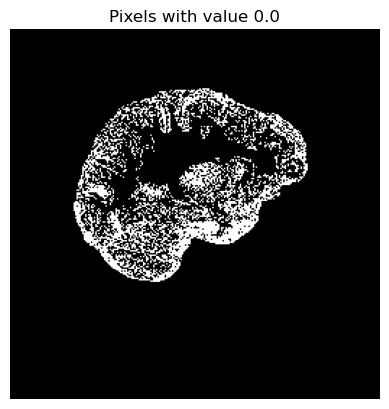

0.0


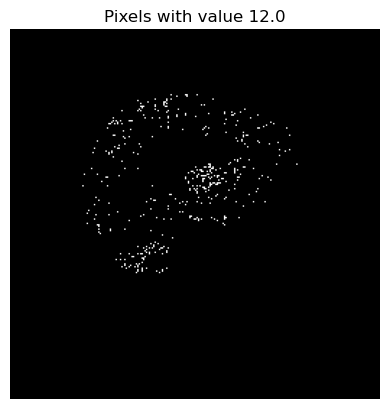

12.0


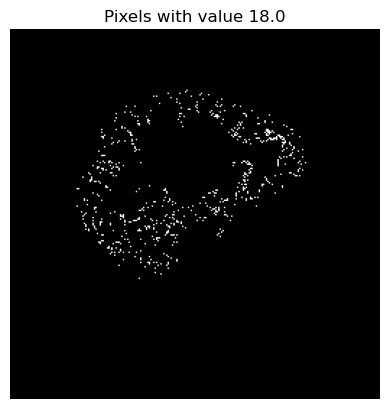

18.0


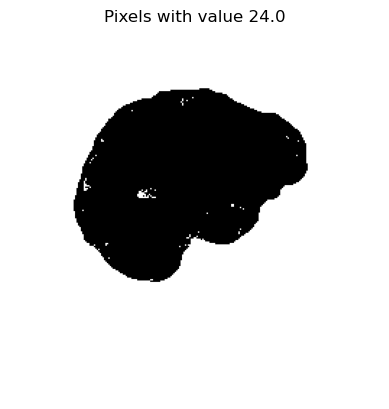

24.0


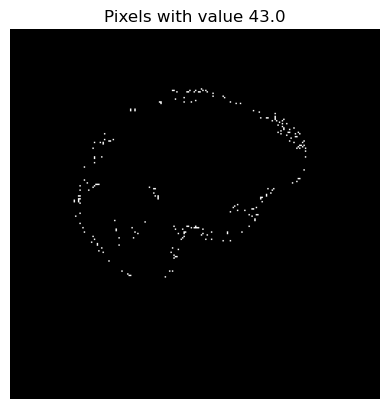

43.0


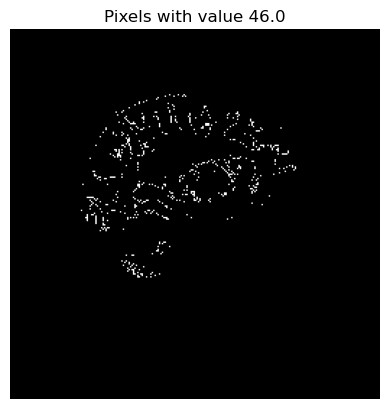

46.0


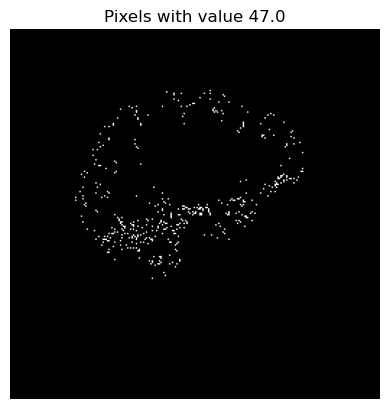

47.0


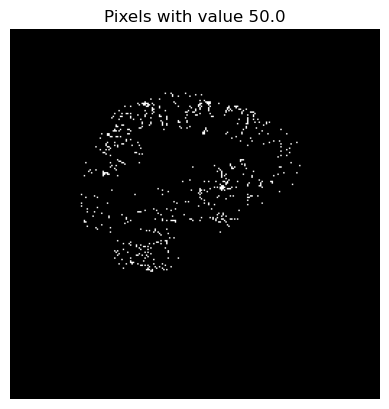

50.0


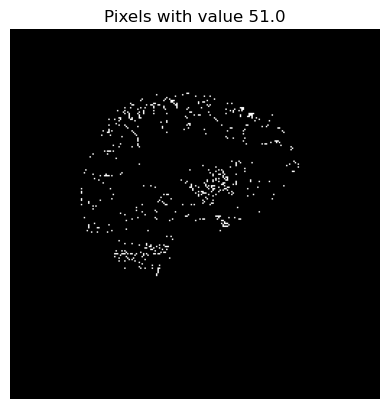

51.0


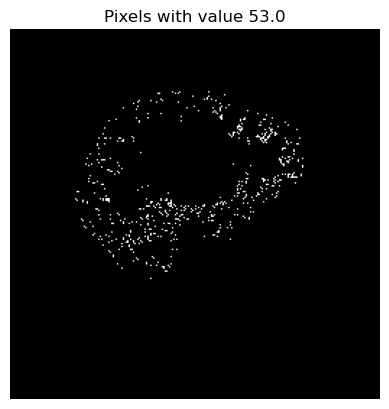

53.0


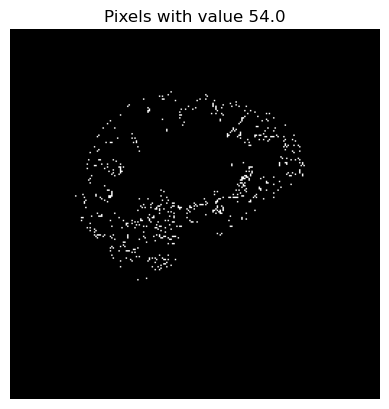

54.0


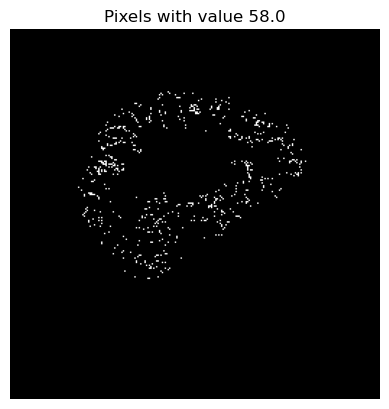

58.0


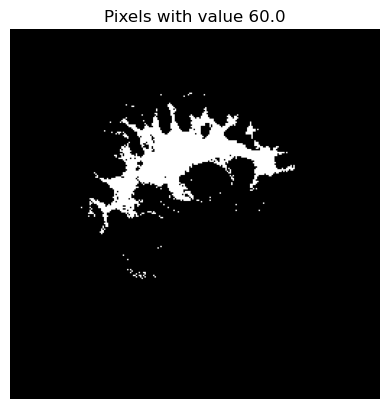

60.0


In [26]:
corrected_data = nib.load('corrected_segmentation.nii')
corrected_data = corrected_data.get_fdata()
unique_vals = np.unique(corrected_data)
import matplotlib.pyplot as plt
for i in unique_vals:
    # Create a binary image where pixels with value i are set to 1, others set to 0
    binary_image = (corrected_data == i).astype(int)
    # Plot the binary image
    plt.imshow(binary_image[100], cmap='gray')
    plt.title(f'Pixels with value {i}')
    plt.axis('off')  # Hide axis for better visualization
    plt.show()
    print(i)

In [32]:
def dice_score_per_label(data1, data2, label):
    mask1 = (data1 == label).astype(int)
    mask2 = (data2 == label).astype(int)
    
    intersection = np.sum(mask1 * mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)
    
    if volume_sum == 0:
        return 1.0  # If both masks are empty, they are perfectly similar
    
    return (2.0 * intersection) / volume_sum

def calculate_multi_class_dice(image1_path, image2_path):
    # Load the NIfTI images
    image1 = nib.load(image1_path)
    image2 = nib.load(image2_path)

    # Get the data arrays
    data1 = image1.get_fdata().astype(int)
    data2 = image2.get_fdata().astype(int)

    # Ensure the data shapes are identical
    if data1.shape != data2.shape:
        raise ValueError("Input images must have the same shape.")
    
    # Identify the unique labels in both images
    unique_labels = np.union1d(np.unique(data1), np.unique(data2))
    
    # Calculate Dice score for each label
    dice_scores = []
    for label in unique_labels:
        score = dice_score_per_label(data1, data2, label)
        dice_scores.append(score)
        print(f"Dice score for label {label}: {score:.4f}")

    # Calculate the average Dice score
    average_dice_score = np.mean(dice_scores)
    
    return average_dice_score

# Example usage
image1_path = 'corrected_segmentation.nii'
image2_path = 'brainmaskconverted_synthseg.nii.gz'
average_dice_score = calculate_multi_class_dice(image1_path, image2_path)
print(f"Average multi-class Dice score: {average_dice_score:.4f}")

Dice score for label 0: 0.0123
Dice score for label 2: 0.0000
Dice score for label 3: 0.0000
Dice score for label 4: 0.0000
Dice score for label 5: 0.0000
Dice score for label 7: 0.0000
Dice score for label 8: 0.0000
Dice score for label 10: 0.0000
Dice score for label 11: 0.0000
Dice score for label 12: 0.0429
Dice score for label 13: 0.0000
Dice score for label 14: 0.0000
Dice score for label 15: 0.0000
Dice score for label 16: 0.0000
Dice score for label 17: 0.0000
Dice score for label 18: 0.0088
Dice score for label 24: 0.0020
Dice score for label 26: 0.0000
Dice score for label 28: 0.0000
Dice score for label 41: 0.0000
Dice score for label 42: 0.0000
Dice score for label 43: 0.0552
Dice score for label 44: 0.0000
Dice score for label 46: 0.0389
Dice score for label 47: 0.0728
Dice score for label 49: 0.0000
Dice score for label 50: 0.0284
Dice score for label 51: 0.0319
Dice score for label 52: 0.0000
Dice score for label 53: 0.0135
Dice score for label 54: 0.0094
Dice score for 

In [31]:
import nibabel as nib
import numpy as np

def dice_score_per_label(data1, data2, label1, label2):
    mask1 = (data1 == label1).astype(int)
    mask2 = (data2 == label2).astype(int)
    
    intersection = np.sum(mask1 * mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)
    
    if volume_sum == 0:
        return 1.0  # If both masks are empty, they are perfectly similar
    
    return (2.0 * intersection) / volume_sum

def calculate_specific_labels_dice(image1_path, image2_path, label1, label2):
    # Load the NIfTI images
    image1 = nib.load(image1_path)
    image2 = nib.load(image2_path)

    # Get the data arrays
    data1 = image1.get_fdata().astype(int)
    data2 = image2.get_fdata().astype(int)

    # Ensure the data shapes are identical
    if data1.shape != data2.shape:
        raise ValueError("Input images must have the same shape.")
    
    # Calculate Dice score for the specified labels
    dice_score = dice_score_per_label(data1, data2, label1, label2)
    
    return dice_score

# Example usage
image1_path = 'brainmaskconverted_synthseg.nii.gz'
image2_path = 'test.nii.gz'
label1 = 41.0 # Specify the label in the first image
label2 = 10  # Specify the corresponding label in the second image

dice_score = calculate_specific_labels_dice(image1_path, image2_path, label1, label2)
print(f"Dice score for label {label1} in image1 and label {label2} in image2: {dice_score:.4f}")

Dice score for label 41.0 in image1 and label 10 in image2: 0.4969


# DBSCAN

In [1]:
from sklearn.cluster import DBSCAN
import nibabel as nib
import numpy as np
from sklearn.preprocessing import StandardScaler

def apply_dbscan_and_save(image_path, output_path, eps=0.5, min_samples=5, chunk_size=100):
    # Load the NIfTI image
    image = nib.load(image_path)
    data = image.get_fdata()
    
    # Get the shape of the data
    x, y, z = data.shape
    
    # Initialize an empty array for clustered data
    clustered_data = np.zeros(data.shape, dtype=np.int32)
    
    # Process the data in chunks
    for i in range(0, z, chunk_size):
        print(f"Processing chunk {i+1}-{min(i+chunk_size, z)}/{z}")
        chunk_data = data[:, :, i:min(i+chunk_size, z)]
        
        # Flatten the chunk data for clustering
        flat_data = chunk_data.reshape(-1, 1)
        
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(flat_data)
        
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data)
        
        # Reshape the labels back to the original chunk shape
        clustered_chunk = labels.reshape(chunk_data.shape)
        
        # Store the clustered chunk in the output array
        clustered_data[:, :, i:min(i+chunk_size, z)] = clustered_chunk
    
    # Save the clustered data as a new NIfTI image
    clustered_image = nib.Nifti1Image(clustered_data, image.affine, image.header)
    nib.save(clustered_image, output_path)
    
    print(f"Clustered image saved as '{output_path}'")

# Example usage
input_image_path = 'brainmaskconverted.nii.gz'
output_image_path = 'clustered_dbscan.nii.gz'
apply_dbscan_and_save(input_image_path, output_image_path, eps=0.5, min_samples=5)

Processing chunk 1-100/256


In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import nibabel as nib
import numpy as np

def apply_hierarchical_clustering_and_save(image_path, output_path, n_clusters=10, affinity='euclidean', linkage='ward', chunk_size=100):
    # Load the NIfTI image
    image = nib.load(image_path)
    data = image.get_fdata()
    
    # Get the shape of the data
    x, y, z = data.shape
    
    # Initialize an empty array for clustered data
    clustered_data = np.zeros(data.shape, dtype=np.int32)
    
    # Process the data in chunks
    for i in range(0, z, chunk_size):
        print(f"Processing chunk {i+1}-{min(i+chunk_size, z)}/{z}")
        chunk_data = data[:, :, i:min(i+chunk_size, z)]
        
        # Flatten the chunk data for clustering
        flat_data = chunk_data.reshape(-1, 1)
        
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(flat_data)
        
        # Apply hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = clustering.fit_predict(scaled_data)
        
        # Reshape the labels back to the original chunk shape
        clustered_chunk = labels.reshape(chunk_data.shape)
        
        # Store the clustered chunk in the output array
        clustered_data[:, :, i:min(i+chunk_size, z)] = clustered_chunk
    
    # Save the clustered data as a new NIfTI image
    clustered_image = nib.Nifti1Image(clustered_data, image.affine, image.header)
    nib.save(clustered_image, output_path)
    
    print(f"Clustered image saved as '{output_path}'")

# Example usage
input_image_path = 'brainmaskconverted.nii.gz'
output_image_path = 'clustered_hierar.nii.gz'
apply_hierarchical_clustering_and_save(input_image_path, output_image_path, n_clusters=10, affinity='euclidean', linkage='ward', chunk_size=50)

Processing chunk 1-50/256


MemoryError: Unable to allocate 39.1 TiB for an array with shape (5368707481600,) and data type float64

Text(0, 0.5, 'Dice score')

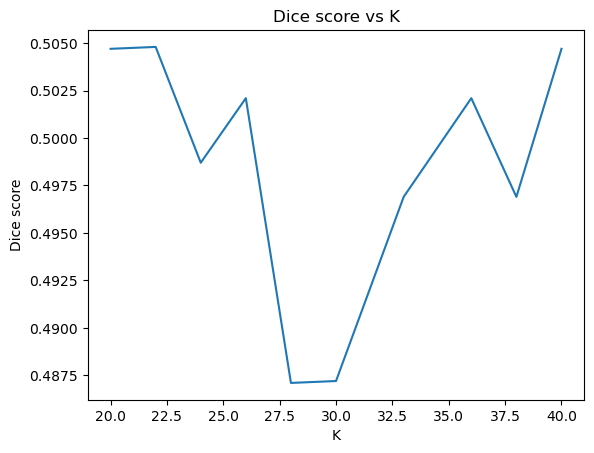

In [37]:
x = [20,22,24,26,28,30,33,36,38,40]
y = [0.5047, 0.5048, 0.4987, 0.5021, 0.4871, 0.4872, 0.4969, 0.5021, 0.4969, 0.5047]

plt.plot(x,y)
plt.title("Dice score vs K")
plt.xlabel("K")
plt.ylabel("Dice score")